In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
from xesmf.backend import (esmf_grid, esmf_regrid_build,
                           esmf_regrid_apply, esmf_regrid_finalize)
from pathlib import Path
import glob

In [11]:
dir_gn = "/Users/keturner/ENOI/calculate_drifts/"
dir_gr = "/Users/keturner/ENOI/calculate_drifts/drifts_regridded/"

In [3]:
models = ["ACCESS", "CanESM", "CESM", "IPSL", "MPI", "UKESM", "NorESM"]
ovars = ["dissic", "so", "thetao"]

In [4]:
v = ovars[0]
m = models[0]
v, m

('dissic', 'ACCESS')

In [5]:
ds_gn = xr.open_zarr(f"{dir_gn}drift_100yr_{v}_{m}")
ds_gn

<xarray.Dataset>
Dimensions:      (lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * i            (i) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j            (j) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
    lat          (j, i) float64 dask.array<chunksize=(50, 360), meta=np.ndarray>
  * lev          (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lon          (j, i) float64 dask.array<chunksize=(50, 360), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    drift_100yr  (lev, j, i) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    lev_bnds     (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>

In [6]:
ds_gn_dissic = xr.open_zarr(f"{dir_gn}drift_100yr_dissic_{m}")

if (m == "IPSL"):
    ds_gn = ds_gn.assign_coords(lat=(('y', 'x'), ds_gn_dissic.lat.data), 
                                lon=(('y', 'x'), ds_gn_dissic.lon.data))
    ds_gn = ds_gn.rename({"olevel":"lev"})
elif (m != "CESM"):
    ds_gn = ds_gn.assign_coords(lat=(('j', 'i'), ds_gn_dissic.lat.data), 
                                lon=(('j', 'i'), ds_gn_dissic.lon.data))

ds_gn = ds_gn.assign(lev_bnds=ds_gn_dissic["lev_bnds"])
ds_gn

<xarray.Dataset>
Dimensions:      (lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * i            (i) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j            (j) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
    lat          (j, i) float64 dask.array<chunksize=(50, 360), meta=np.ndarray>
  * lev          (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lon          (j, i) float64 dask.array<chunksize=(50, 360), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    drift_100yr  (lev, j, i) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    lev_bnds     (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>

In [7]:
ds_gr = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90.5, 1)), 
                    'lon': (['lon'], np.arange(0.5, 360.5, 1)), 
                    'lat_b': (['lat_b'], np.arange(-90, 91, 1)), 
                    'lon_b': (['lon_b'], np.arange(0,361,1))})

ds_gr

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, lat_b: 181, lon_b: 361)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat_b    (lat_b) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon_b    (lon_b) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
Data variables:
    *empty*

In [8]:
regridder = xe.Regridder(ds_gn, ds_gr, 'bilinear', ignore_degenerate=True, periodic=True)

dr_regrid = regridder(ds_gn.drift_100yr)
ds_gr = dr_regrid.to_dataset(name="drift_100yr_gr")
ds_gr = xr.merge([ds_gr, ds_gn['lev_bnds']])

ds_gr

<xarray.Dataset>
Dimensions:         (lev: 50, lat: 180, lon: 360, bnds: 2)
Coordinates:
  * lev             (lev) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    drift_100yr_gr  (lev, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lev_bnds        (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>

In [12]:
ds_gr.to_netcdf(f"{dir_gr}drift_100yr_{v}_{m}_1x1.nc")

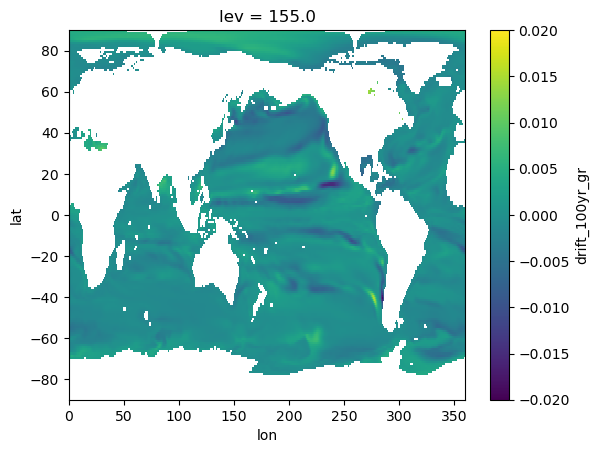

In [15]:
test = xr.open_dataset(f"{dir_gr}drift_100yr_{v}_{m}_1x1.nc")
test.drift_100yr_gr[15,:,:].plot(vmin=-0.02, vmax=0.02)

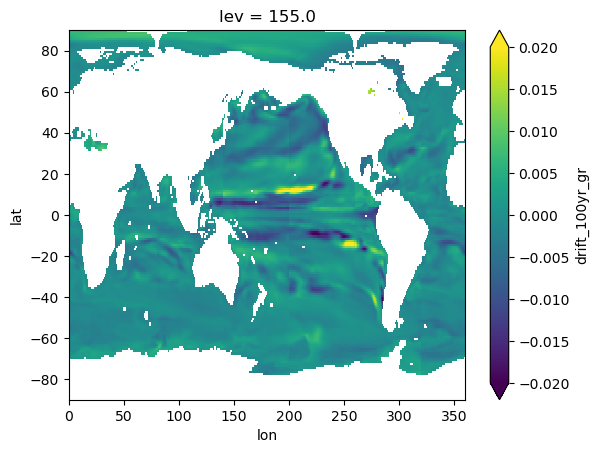

In [16]:
test2 = xr.open_dataset(f"{dir_gr}OLD_drift_100yr_{v}_{m}_1x1_OLD.nc")
test2.drift_100yr_gr[15,:,:].plot(vmin=-0.02, vmax=0.02)

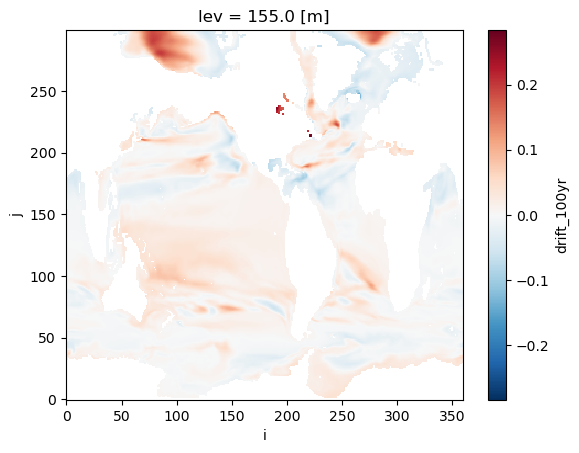

In [11]:
ds_gn.drift_100yr[15,:,:].plot()